In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from behav_analysis import Data_Functions, Participant_Behav
    
class Participant_Watch():
    def __init__(self, par_num):
        self.data_fun = Data_Functions()
        self.par_num = par_num
        self.par_ID = f"participant_{self.par_num}"
        self.par_dir = os.path.join(os.getcwd(), "participants", self.par_ID)
        self.par_behav = Participant_Behav(par_num=self.par_num)
        self.exp_order = self.par_behav.exp_order
        self._dir_list = self._get_data_dirs()
        
        self.modalities = ["ACC", "BVP", "EDA", "HR", "IBI", "TEMP"]
        self.modality_df_dict = self._create_modality_df_dict()
        self.marker_ts_df = self.par_behav.marker_ts_df
        self.exp_modality_data_dict = self._create_exp_modality_dict()

    def _get_data_dirs(self):
        watch_dir = os.path.join(self.par_dir, "watch_data")
        dir_list = []
        for dir_name in os.listdir(watch_dir):
            dir_list.append(os.path.join(watch_dir, dir_name))

        return dir_list

    def _create_modality_df(self, modality):
        df_list = []
        for watch_dir in self._dir_list:
            filepath = os.path.join(watch_dir, modality + ".csv")
            temp_df = pd.read_csv(filepath)
            initial_ts = int(float(temp_df.columns[0]))
            if modality != "IBI":
                samp_freq = int(temp_df.iloc[0][0])
                ts_col = pd.Series([initial_ts + i/samp_freq for i in range(temp_df.size)])
                dt_col = pd.Series([datetime.datetime.fromtimestamp(ts) for ts in ts_col])
                temp_df = temp_df[1:]
                temp_df.insert(loc=0, column="timestamps", value=ts_col)
                temp_df.insert(loc=1, column="datetime", value=dt_col)

                if modality == "ACC":
                    temp_df.rename(columns={temp_df.columns[2]: "accel_x", temp_df.columns[3]: "accel_y", temp_df.columns[4]: "accel_z"}, inplace=True)
                    temp_df["accel_x"] = temp_df["accel_x"]/64
                    temp_df["accel_y"] = temp_df["accel_y"]/64
                    temp_df["accel_z"] = temp_df["accel_z"]/64
                elif modality == "BVP" or modality == "EDA" or modality == "HR":
                    temp_df.rename(columns={temp_df.columns[2]: modality}, inplace=True)    
                elif modality == "TEMP":
                    temp_df.rename(columns={temp_df.columns[2]: "TEMP_C"}, inplace=True)
                    temp_F_col = pd.Series([self.data_fun.c_to_f(temp_C) for temp_C in temp_df["TEMP_C"]])
                    temp_df = temp_df.drop(columns="TEMP_C")
                    temp_df.insert(loc=2, column="TEMP", value=temp_F_col)
            elif modality == "IBI":
                ts_col = temp_df.iloc[:, 0] + initial_ts
                dt_col = pd.Series([datetime.datetime.fromtimestamp(ts) for ts in ts_col])
                temp_df.insert(loc=0, column="timestamps", value=ts_col)
                temp_df.insert(loc=1, column="datetime", value=dt_col)
                temp_df = temp_df.drop(columns=temp_df.columns[2])
                temp_df.rename(columns={temp_df.columns[2]: modality}, inplace=True)    
            df_list.append(temp_df)
        df = pd.concat(df_list, axis=0)
        df.reset_index(inplace=True, drop=True)

        return df

    def _create_modality_df_dict(self):
        modality_df_dict = {}
        for modality in self.modalities:
            modality_df_dict[modality] = self._create_modality_df(modality)
        
        return modality_df_dict

    def _create_exp_modality_dict(self):
        exp_modality_dict = {}
        for exp_name in self.exp_order:
            start_dt, end_dt = self.data_fun.get_exp_dt(self.marker_ts_df, exp_name=exp_name)
            exp_modality_data_dict = {} 
            for modality, df in self.modality_df_dict.items():
                start_idx = self.data_fun.get_start_index_dt(df=self.modality_df_dict[modality], start_dt=start_dt)
                end_idx = self.data_fun.get_end_index_dt(df=self.modality_df_dict[modality], end_dt=end_dt)
                modality_data = self.modality_df_dict[modality].iloc[start_idx:end_idx]
                exp_modality_data_dict[modality] = modality_data
            exp_modality_dict[exp_name] = exp_modality_data_dict

        return exp_modality_dict

    def _plot_exp_regions(self, ax):
        for exp_name in self.exp_order:
            start_dt, end_dt = self.data_fun.get_exp_dt(self.marker_ts_df, exp_name=exp_name)
            ax.axvline(start_dt, linestyle="dashed", color="k", alpha=0.75)
            ax.axvline(end_dt, linestyle="dashed", color="k", alpha=0.75)
            if exp_name == "audio_narrative":
                ax.axvspan(start_dt, end_dt, color="yellow", alpha=0.4, label="Audio Narrative")
            elif exp_name == "go_no_go":
                ax.axvspan(start_dt, end_dt, color="green", alpha=0.4, label="Go//No-Go")
            elif exp_name == "king_devick":
                ax.axvspan(start_dt, end_dt, color="blue", alpha=0.4, label="King Devick")
            elif exp_name == "n_back":
                ax.axvspan(start_dt, end_dt, color="purple", alpha=0.4, label="N-back")
            elif exp_name == "resting_state":
                ax.axvspan(start_dt, end_dt, color="pink", alpha=0.4, label="Resting State")
            elif exp_name == "tower_of_london":
                ax.axvspan(start_dt, end_dt, color="orange", alpha=0.4, label="Tower of London")
            elif exp_name == "video_narrative_cmiyc":
                ax.axvspan(start_dt, end_dt, color="red", alpha=0.4, label="Video Narrative CMIYC")
            elif exp_name == "video_narrative_sherlock":
                ax.axvspan(start_dt, end_dt, color="olive", alpha=0.4, label="Video Narrative Sherlock")
            elif exp_name == "vSAT":
                ax.axvspan(start_dt, end_dt, color="cyan", alpha=0.4, label="vSAT")

    def plot_modality(self, modality):
        datetime_fmt = mdates.DateFormatter('%H:%M:%S')
        modality_df = self.modality_df_dict[modality]
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
        
        if modality == "ACC":
            ax.plot(modality_df["datetime"], modality_df["accel_x"], color="black")
            ax.plot(modality_df["datetime"], modality_df["accel_y"], color="darkslategray")
            ax.plot(modality_df["datetime"], modality_df["accel_z"], color="darkblue")
            ax.set_ylabel("Acceleration (g)", fontsize=16, color="k")
            ax.set_title("Acceleration", fontsize=20, color="k")
        elif modality == "BVP":
            ax.plot(modality_df["datetime"], modality_df["BVP"], color="k")
            ax.set_ylabel("BVP", fontsize=16, color="k")
            ax.set_title("Photoplethysmograph", fontsize=20, color="k")
        elif modality == "EDA":
            ax.plot(modality_df["datetime"], modality_df["EDA"], color="k")
            ax.set_ylabel("EDA (μS)", fontsize=16, color="k")
            ax.set_title("Electrodermal", fontsize=20, color="k")
        elif modality == "HR":
            ax.plot(modality_df["datetime"], modality_df["HR"], color="k")
            ax.set_ylabel("Heart Rate (BPM)", fontsize=16, color="k")
            ax.set_title("Heart Rate", fontsize=20, color="k")
        elif modality == "IBI":
            ax.plot(modality_df["datetime"], modality_df["IBI"], color="k")
            ax.set_ylabel("Interbeat Interval (seconds)", fontsize=16, color="k")
            ax.set_title("Heart Rate Variability", fontsize=20, color="k")
        elif modality == "TEMP":
            ax.plot(modality_df["datetime"], modality_df["TEMP"], color="k")
            ax.set_ylabel("Temperature (F)", fontsize=16, color="k")
            ax.set_title("Temperature", fontsize=20, color="k")

        ax.set_xlabel("Time", fontsize=16, color="k")
        ax.xaxis.set_major_formatter(datetime_fmt)
        self._plot_exp_regions(ax=ax)
        ax.legend(bbox_to_anchor=(1.0, 0.75), facecolor='white', framealpha=1)

def create_watch_results_tables(num_pars):
    def _create_df(par_list, exp, modality):
        temp_df_list = []
        for par in par_list:
            temp_df = pd.DataFrame()
            temp_df[modality] = par.exp_modality_data_dict[exp][modality][modality]
            temp_df.reset_index(inplace=True, drop=True)
            par_num_col = par.data_fun.create_col(par.par_num, num_rows=temp_df.shape[0])
            temp_df.insert(loc=0, column="participant", value=par_num_col)
            temp_df_list.append(temp_df)
        df = pd.concat(temp_df_list, axis=0)
        df.reset_index(inplace=True, drop=True)
        return df

    def _data_to_excel(exp, data_dict):
        filepath = os.path.join(os.getcwd(), "results/watch", f"{exp}_watch.xlsx")
        with pd.ExcelWriter(filepath, engine='xlsxwriter') as writer:
            for modality, df in data_dict.items():
                df.to_excel(writer, sheet_name=modality, index=False)

    par_list = []                
    for i in range(num_pars):
        par_num = f"{(i+1):02d}"
        par = Participant_Watch(par_num=par_num)
        par_list.append(par)

    for exp in par.exp_order:
        data_dict = {}
        for modality in par.modalities: 
            if modality == "ACC":
                temp_df_list = []
                for par in par_list:
                    temp_df = pd.DataFrame()
                    temp_df["accel_x"] = par.exp_modality_data_dict[exp][modality]["accel_x"]
                    temp_df["accel_y"] = par.exp_modality_data_dict[exp][modality]["accel_y"]
                    temp_df["accel_z"] = par.exp_modality_data_dict[exp][modality]["accel_z"]
                    temp_df.reset_index(inplace=True, drop=True)
                    par_num_col = par.data_fun.create_col(par.par_num, num_rows=temp_df.shape[0])
                    temp_df.insert(0, "participant", par_num_col)
                    temp_df_list.append(temp_df)
                ACC_df = pd.concat(temp_df_list, axis=0)
                ACC_df.reset_index(inplace=True, drop=True)
                data_dict[modality] = ACC_df
            elif modality == "BVP" or modality == "EDA" or modality == "HR" or modality == "IBI" or modality == "TEMP":
                data_dict[modality] = _create_df(par_list, exp, modality)

        _data_to_excel(exp, data_dict)

In [2]:
#num_pars = 13
#create_watch_results_tables(num_pars=num_pars)

In [3]:
par_num = "04"
par = Participant_Watch(par_num=par_num)

c:\Users\zackg\OneDrive\Ayaz Lab\KernelFlow_Analysis\behav_analysis.py:628: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_simp.drop(columns=["x_pos", "y_pos"], inplace=True)


In [4]:
exp_name = "resting_state"
modality = "HR"
exp = par.par_behav.get_exp(exp_name=exp_name)
print("Num blocks:", exp.num_blocks)
df = par.exp_modality_data_dict[exp_name][modality]
df = df.reset_index()
num_rows = df.shape[0]
print("Num rows:", num_rows)

col_list = []
for i, (ts_tuple, block) in enumerate(par.par_behav.by_block_ts_df[exp_name].items()):
    print(ts_tuple, block)
    start_ts = ts_tuple[0]
    end_ts =  ts_tuple[1]
    block_start_idx = par.data_fun.get_start_index_ts(df, start_ts)
    block_end_idx = par.data_fun.get_end_index_ts(df, end_ts)
    print(block_start_idx, block_end_idx)
    if i == 0:
        col_list.append(par.data_fun.create_col(None, block_start_idx))
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
    elif i == exp.num_blocks-1:
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
        col_list.append(par.data_fun.create_col(None, num_rows-block_end_idx))
    else:
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
test = pd.concat(col_list, axis=0, ignore_index=True)
df.insert(0, "block", test)
df

Num blocks: 2
Num rows: 442
(1657310771.7601109, 1657310981.7468605) eyes_open
23 233
(1657310981.7468607, 1657311191.766944) eyes_closed
233 441


,block,index,timestamps,datetime,HR
0,None,4652,1.657311e+09,2022-07-08 16:05:49,70.30
1,None,4653,1.657311e+09,2022-07-08 16:05:50,70.25
2,None,4654,1.657311e+09,2022-07-08 16:05:51,70.22
3,None,4655,1.657311e+09,2022-07-08 16:05:52,70.20
4,None,4656,1.657311e+09,2022-07-08 16:05:53,70.18
...,...,...,...,...,...
437,eyes_closed,5089,1.657311e+09,2022-07-08 16:13:06,67.32
438,eyes_closed,5090,1.657311e+09,2022-07-08 16:13:07,67.32
439,eyes_closed,5091,1.657311e+09,2022-07-08 16:13:08,67.32
440,eyes_closed,5092,1.657311e+09,2022-07-08 16:13:09,67.32


In [5]:
df = pd.DataFrame()
exp_name = "audio_narrative"
modality = "HR"
exp = par.par_behav.get_exp(exp_name=exp_name)
print("Num blocks:", exp.num_blocks)
df = par.exp_modality_data_dict[exp_name][modality]
df = df.reset_index()
num_rows = df.shape[0]
print("Num rows:", num_rows)

col_list = []
for ts_tuple, block in par.par_behav.by_block_ts_df[exp_name].items():
    print(ts_tuple, block)
    start_ts = ts_tuple[0]
    end_ts =  ts_tuple[1]
    block_start_idx = par.data_fun.get_start_index_ts(df, start_ts)
    block_end_idx = par.data_fun.get_end_index_ts(df, end_ts)
    print(block_start_idx, block_end_idx)
    col_list.append(par.data_fun.create_col(None, block_start_idx))
    col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
    col_list.append(par.data_fun.create_col(None, num_rows-block_end_idx))
test2 = pd.concat(col_list, axis=0, ignore_index=True)
df.insert(0, "block", test2)
df

Num blocks: 1
Num rows: 438
(1657309887.9292092, 1657310310.9292092) audio_narrative
19 437


,block,index,timestamps,datetime,HR
0,None,3772,1.657310e+09,2022-07-08 15:51:09,71.58
1,None,3773,1.657310e+09,2022-07-08 15:51:10,71.53
2,None,3774,1.657310e+09,2022-07-08 15:51:11,71.48
3,None,3775,1.657310e+09,2022-07-08 15:51:12,71.43
4,None,3776,1.657310e+09,2022-07-08 15:51:13,71.38
...,...,...,...,...,...
433,audio_narrative,4205,1.657310e+09,2022-07-08 15:58:22,74.77
434,audio_narrative,4206,1.657310e+09,2022-07-08 15:58:23,74.73
435,audio_narrative,4207,1.657310e+09,2022-07-08 15:58:24,74.65
436,audio_narrative,4208,1.657310e+09,2022-07-08 15:58:25,74.57


In [6]:
df = pd.DataFrame()
exp_name = "video_narrative_cmiyc"
modality = "HR"
exp = par.par_behav.get_exp(exp_name=exp_name)
print("Num blocks:", exp.num_blocks)
df = par.exp_modality_data_dict[exp_name][modality]
df = df.reset_index()
num_rows = df.shape[0]
print("Num rows:", num_rows)

col_list = []
for ts_tuple, block in par.par_behav.by_block_ts_df[exp_name].items():
    print(ts_tuple, block)
    start_ts = ts_tuple[0]
    end_ts =  ts_tuple[1]
    block_start_idx = par.data_fun.get_start_index_ts(df, start_ts)
    block_end_idx = par.data_fun.get_end_index_ts(df, end_ts)
    print(block_start_idx, block_end_idx)
    col_list.append(par.data_fun.create_col(None, block_start_idx))
    col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
    col_list.append(par.data_fun.create_col(None, num_rows-block_end_idx))
test3 = pd.concat(col_list, axis=0, ignore_index=True)
df.insert(0, "block", test3)
df

Num blocks: 1
Num rows: 344
(1657308241.1030607, 1657308541.1030607) video_narrative_cmiyc
48 343


,block,index,timestamps,datetime,HR
0,None,2097,1.657308e+09,2022-07-08 15:23:14,73.97
1,None,2098,1.657308e+09,2022-07-08 15:23:15,73.97
2,None,2099,1.657308e+09,2022-07-08 15:23:16,74.00
3,None,2100,1.657308e+09,2022-07-08 15:23:17,74.05
4,None,2101,1.657308e+09,2022-07-08 15:23:18,74.13
...,...,...,...,...,...
339,video_narrative_cmiyc,2436,1.657309e+09,2022-07-08 15:28:53,69.37
340,video_narrative_cmiyc,2437,1.657309e+09,2022-07-08 15:28:54,69.43
341,video_narrative_cmiyc,2438,1.657309e+09,2022-07-08 15:28:55,69.50
342,video_narrative_cmiyc,2439,1.657309e+09,2022-07-08 15:28:56,69.55


In [7]:
df = pd.DataFrame()
exp_name = "video_narrative_sherlock"
modality = "HR"
exp = par.par_behav.get_exp(exp_name=exp_name)
print("Num blocks:", exp.num_blocks)
df = par.exp_modality_data_dict[exp_name][modality]
df = df.reset_index()
num_rows = df.shape[0]
print("Num rows:", num_rows)

col_list = []
for ts_tuple, block in par.par_behav.by_block_ts_df[exp_name].items():
    print(ts_tuple, block)
    start_ts = ts_tuple[0]
    end_ts =  ts_tuple[1]
    block_start_idx = par.data_fun.get_start_index_ts(df, start_ts)
    block_end_idx = par.data_fun.get_end_index_ts(df, end_ts)
    print(block_start_idx, block_end_idx)
    col_list.append(par.data_fun.create_col(None, block_start_idx))
    col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
    col_list.append(par.data_fun.create_col(None, num_rows-block_end_idx))
test4 = pd.concat(col_list, axis=0, ignore_index=True)
df.insert(0, "block", test4)
df

Num blocks: 1
Num rows: 317
(1657311809.6945548, 1657312109.6945548) video_narrative_sherlock
20 316


,block,index,timestamps,datetime,HR
0,None,5693,1.657312e+09,2022-07-08 16:23:10,65.20
1,None,5694,1.657312e+09,2022-07-08 16:23:11,65.10
2,None,5695,1.657312e+09,2022-07-08 16:23:12,65.00
3,None,5696,1.657312e+09,2022-07-08 16:23:13,64.93
4,None,5697,1.657312e+09,2022-07-08 16:23:14,64.87
...,...,...,...,...,...
312,video_narrative_sherlock,6005,1.657312e+09,2022-07-08 16:28:22,60.93
313,video_narrative_sherlock,6006,1.657312e+09,2022-07-08 16:28:23,60.80
314,video_narrative_sherlock,6007,1.657312e+09,2022-07-08 16:28:24,60.67
315,video_narrative_sherlock,6008,1.657312e+09,2022-07-08 16:28:25,60.55


In [8]:
print(end_ts)
par.data_fun.get_end_index_ts(df, end_ts)
print(datetime.datetime.fromtimestamp(end_ts))

1657312109.6945548
2022-07-08 16:28:29.694555


In [9]:
df = pd.DataFrame()
exp_name = "n_back"
modality = "HR"
print("Num blocks:", exp.num_blocks)
df = par.exp_modality_data_dict[exp_name][modality]
df = df.reset_index()
num_rows = df.shape[0]
print("Num rows:", num_rows)

col_list = []
for ts_tuple, block in par.par_behav.by_block_ts_df[exp_name].items():
    print(ts_tuple, block)
    start_ts = ts_tuple[0]
    end_ts =  ts_tuple[1]
    block_start_idx = par.data_fun.get_start_index_ts(df, start_ts)
    block_end_idx = par.data_fun.get_end_index_ts(df, end_ts)
    print(block_start_idx, block_end_idx)
    if i == 0:
        col_list.append(par.data_fun.create_col(None, block_start_idx))
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
    elif i == exp.num_blocks-1:
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
        col_list.append(par.data_fun.create_col(None, num_rows-block_end_idx))
    else:
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
test5 = pd.concat(col_list, axis=0, ignore_index=True)
df.insert(0, "block", test5)
df

Num blocks: 1
Num rows: 804
(1657307388.3222992, 1657307455.3233695) OB
37 104
(1657307475.9570749, 1657307542.9581342) TB
124 191
(1657307577.7420244, 1657307644.7431123) TB
226 293
(1657307668.2602174, 1657307735.261261) ZB
317 384
(1657307753.428268, 1657307820.4293184) OB
402 469
(1657307839.7796614, 1657307906.7807233) ZB
488 555
(1657307921.5976899, 1657307988.5987146) OB
570 637
(1657308003.415643, 1657308070.4167187) ZB
652 719
(1657308085.900382, 1657308152.9013786) TB
734 801


,block,index,timestamps,datetime,HR
0,OB,1255,1.657307e+09,2022-07-08 15:09:12,76.48
1,OB,1256,1.657307e+09,2022-07-08 15:09:13,76.63
2,OB,1257,1.657307e+09,2022-07-08 15:09:14,76.80
3,OB,1258,1.657307e+09,2022-07-08 15:09:15,76.98
4,OB,1259,1.657307e+09,2022-07-08 15:09:16,77.17
...,...,...,...,...,...
799,NaN,2054,1.657308e+09,2022-07-08 15:22:31,75.13
800,NaN,2055,1.657308e+09,2022-07-08 15:22:32,75.17
801,NaN,2056,1.657308e+09,2022-07-08 15:22:33,75.20
802,NaN,2057,1.657308e+09,2022-07-08 15:22:34,75.23


In [10]:
df = pd.DataFrame()
exp_name = "tower_of_london"
modality = "HR"
print("Num blocks:", exp.num_blocks)
df = par.exp_modality_data_dict[exp_name][modality]
df = df.reset_index()
num_rows = df.shape[0]
print("Num rows:", num_rows)

col_list = []
for ts_tuple, block in par.par_behav.by_block_ts_df[exp_name].items():
    print(ts_tuple, block)
    start_ts = ts_tuple[0]
    end_ts =  ts_tuple[1]
    block_start_idx = par.data_fun.get_start_index_ts(df, start_ts)
    block_end_idx = par.data_fun.get_end_index_ts(df, end_ts)
    print(block_start_idx, block_end_idx)
    if i == 0:
        col_list.append(par.data_fun.create_col(None, block_start_idx))
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
    elif i == exp.num_blocks-1:
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
        col_list.append(par.data_fun.create_col(None, num_rows-block_end_idx))
    else:
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
test6 = pd.concat(col_list, axis=0, ignore_index=True)
df.insert(0, "block", test6)
df

Num blocks: 1
Num rows: 420
(1657306735.1120174, 1657306795.0462592) MM
21 81
(1657306803.629764, 1657306863.6140368) ZM
89 149
(1657306870.314214, 1657306930.2984586) MM
156 216
(1657306941.1987236, 1657307001.1829362) ZM
227 287
(1657307007.7831485, 1657307067.76737) MM
293 353
(1657307073.1008317, 1657307133.0850956) ZM
359 419


,block,index,timestamps,datetime,HR
0,MM,618,1.657307e+09,2022-07-08 14:58:35,66.47
1,MM,619,1.657307e+09,2022-07-08 14:58:36,66.53
2,MM,620,1.657307e+09,2022-07-08 14:58:37,66.57
3,MM,621,1.657307e+09,2022-07-08 14:58:38,66.57
4,MM,622,1.657307e+09,2022-07-08 14:58:39,66.58
...,...,...,...,...,...
415,NaN,1033,1.657307e+09,2022-07-08 15:05:30,70.35
416,NaN,1034,1.657307e+09,2022-07-08 15:05:31,70.25
417,NaN,1035,1.657307e+09,2022-07-08 15:05:32,70.15
418,NaN,1036,1.657307e+09,2022-07-08 15:05:33,70.05


In [11]:
df = pd.DataFrame()
exp_name = "go_no_go"
modality = "HR"
print("Num blocks:", exp.num_blocks)
df = par.exp_modality_data_dict[exp_name][modality]
df = df.reset_index()
num_rows = df.shape[0]
print("Num rows:", num_rows)

col_list = []
for ts_tuple, block in par.par_behav.by_block_ts_df[exp_name].items():
    print(ts_tuple, block)
    start_ts = ts_tuple[0]
    end_ts =  ts_tuple[1]
    block_start_idx = par.data_fun.get_start_index_ts(df, start_ts)
    block_end_idx = par.data_fun.get_end_index_ts(df, end_ts)
    print(block_start_idx, block_end_idx)
    if i == 0:
        col_list.append(par.data_fun.create_col(None, block_start_idx))
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
    elif i == exp.num_blocks-1:
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
        col_list.append(par.data_fun.create_col(None, num_rows-block_end_idx))
    else:
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
test7 = pd.concat(col_list, axis=0, ignore_index=True)
df.insert(0, "block", test7)
df

Num blocks: 1
Num rows: 545
(1657311247.034595, 1657311369.72021) go
28 150
(1657311378.003417, 1657311511.0222254) GNG
159 292
(1657311517.9723556, 1657311630.724452) go
298 411
(1657311634.6576104, 1657311757.676552) GNG
415 538


,block,index,timestamps,datetime,HR
0,go,5123,1.657311e+09,2022-07-08 16:13:40,66.52
1,go,5124,1.657311e+09,2022-07-08 16:13:41,66.45
2,go,5125,1.657311e+09,2022-07-08 16:13:42,66.37
3,go,5126,1.657311e+09,2022-07-08 16:13:43,66.32
4,go,5127,1.657311e+09,2022-07-08 16:13:44,66.28
...,...,...,...,...,...
540,NaN,5663,1.657312e+09,2022-07-08 16:22:40,66.10
541,NaN,5664,1.657312e+09,2022-07-08 16:22:41,65.95
542,NaN,5665,1.657312e+09,2022-07-08 16:22:42,65.82
543,NaN,5666,1.657312e+09,2022-07-08 16:22:43,65.73


In [12]:
df = pd.DataFrame()
exp_name = "vSAT"
modality = "HR"
print("Num blocks:", exp.num_blocks)
df = par.exp_modality_data_dict[exp_name][modality]
df = df.reset_index()
num_rows = df.shape[0]
print("Num rows:", num_rows)

col_list = []
for ts_tuple, block in par.par_behav.by_block_ts_df[exp_name].items():
    print(ts_tuple, block)
    start_ts = ts_tuple[0]
    end_ts =  ts_tuple[1]
    block_start_idx = par.data_fun.get_start_index_ts(df, start_ts)
    block_end_idx = par.data_fun.get_end_index_ts(df, end_ts)
    print(block_start_idx, block_end_idx)
    if i == 0:
        col_list.append(par.data_fun.create_col(None, block_start_idx))
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
    elif i == exp.num_blocks-1:
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
        col_list.append(par.data_fun.create_col(None, num_rows-block_end_idx))
    else:
        col_list.append(par.data_fun.create_col(block, block_end_idx-block_start_idx))
test8 = pd.concat(col_list, axis=0, ignore_index=True)
df.insert(0, "block", test8)
df

Num blocks: 1
Num rows: 425
(1657309442.771911, 1657309537.523459) vSAT
25 120
(1657309542.2402017, 1657309632.558326) SAT
125 215
(1657309635.6750662, 1657309738.560046) SAT
218 321
(1657309742.8267963, 1657309843.3284523) vSAT
325 424


,block,index,timestamps,datetime,HR
0,vSAT,3321,1.657309e+09,2022-07-08 15:43:38,67.62
1,vSAT,3322,1.657309e+09,2022-07-08 15:43:39,67.63
2,vSAT,3323,1.657309e+09,2022-07-08 15:43:40,67.63
3,vSAT,3324,1.657309e+09,2022-07-08 15:43:41,67.47
4,vSAT,3325,1.657309e+09,2022-07-08 15:43:42,67.35
...,...,...,...,...,...
420,NaN,3741,1.657310e+09,2022-07-08 15:50:38,70.02
421,NaN,3742,1.657310e+09,2022-07-08 15:50:39,70.07
422,NaN,3743,1.657310e+09,2022-07-08 15:50:40,70.10
423,NaN,3744,1.657310e+09,2022-07-08 15:50:41,70.08


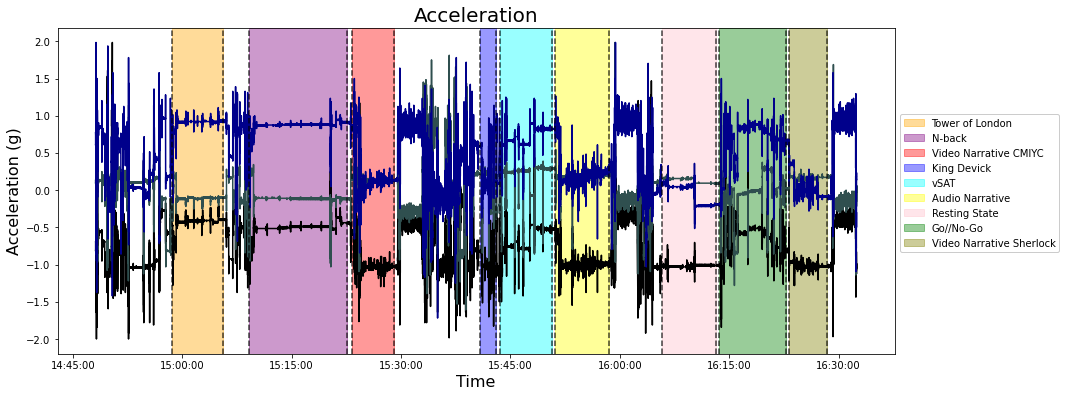

In [13]:
### Accelerometer ###
par.plot_modality("ACC")

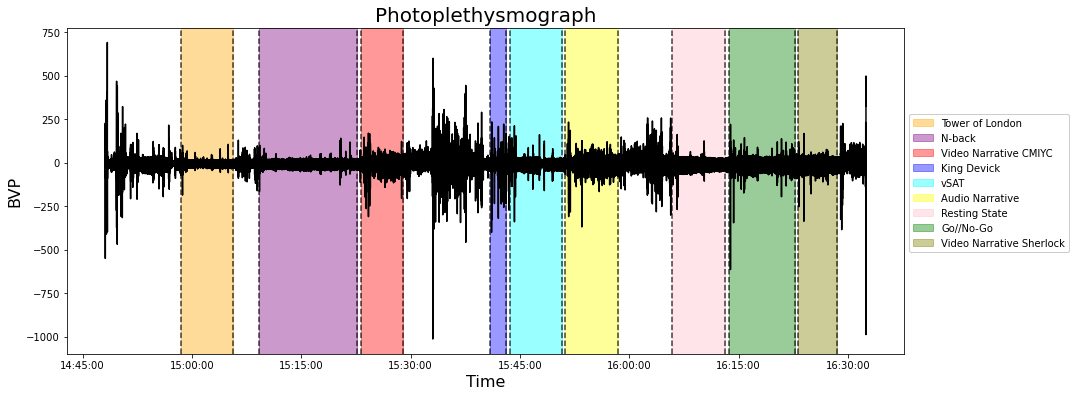

In [14]:
### Photoplethysmograph ###
par.plot_modality("BVP")

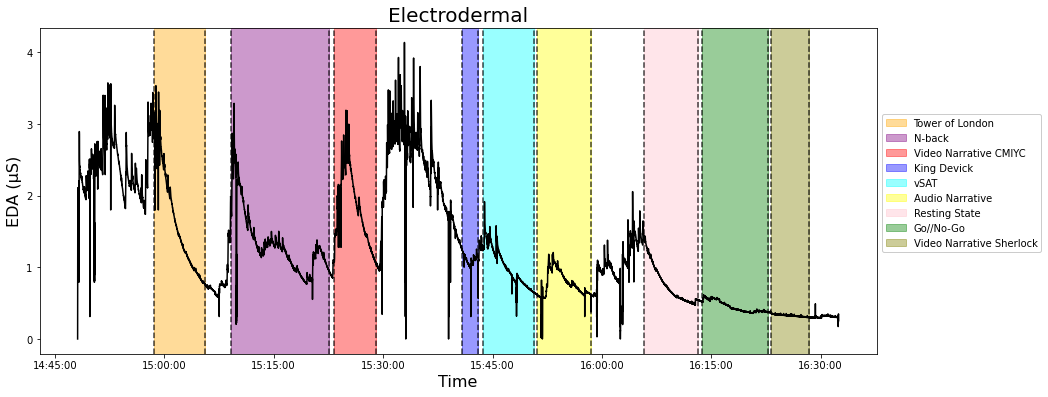

In [15]:
### Electrodermal ###
par.plot_modality("EDA")

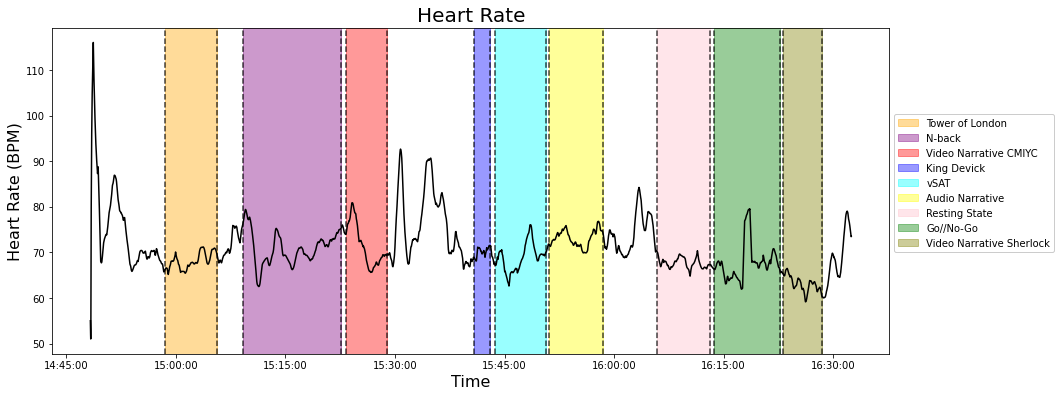

In [16]:
### Heart Rate ###
par.plot_modality("HR")

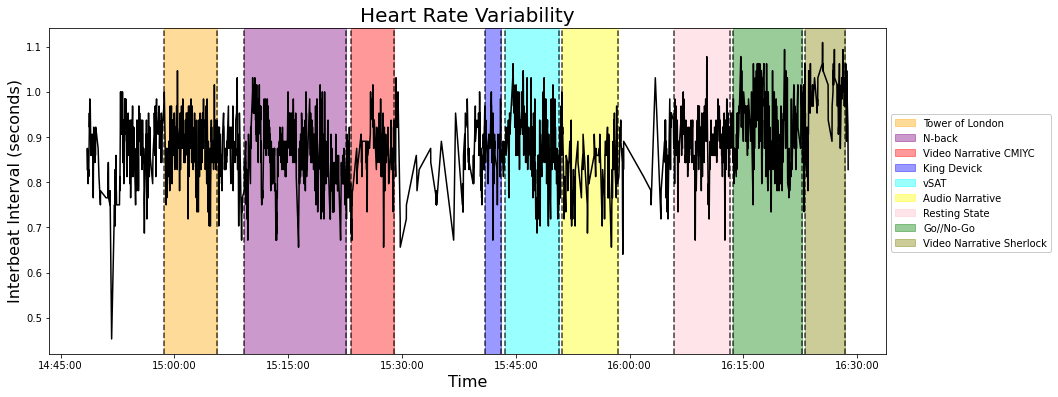

In [17]:
### Interbeat Interval ###
par.plot_modality("IBI")

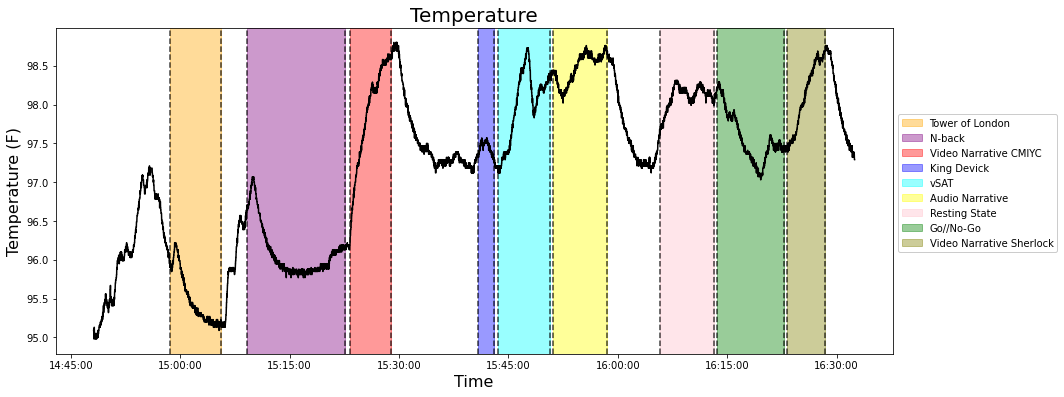

In [18]:
### Temperature ###
par.plot_modality("TEMP")